# Environment
## Обучал локально, однако в коллабе запуститься.

In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-PCIE-16GB (UUID: GPU-772a1ac8-0f5d-4528-4d05-5acbe011d1e0)


In [2]:
! pip install gdown lmdb opencv-python matplotlib torch tqdm wandb onnx

In [3]:
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

Для логирования использую WandB, ccылка на лог в Readme

In [4]:
import wandb

wandb.login()

wandb: Currently logged in as: diffraction-zebra. Use `wandb login --relogin` to force relogin


True

# Dataset


Ссылка на датасет на моем гугл-диске (если слишком часто скачивать, на день заблокируется)

In [ ]:
! gdown https://drive.google.com/file/d/13vtpN31r2imMIDhHt2lhksXhRgsKJhRr/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=13vtpN31r2imMIDhHt2lhksXhRgsKJhRr
From (redirected): https://drive.google.com/uc?id=13vtpN31r2imMIDhHt2lhksXhRgsKJhRr&confirm=t&uuid=a67b74ea-3d4a-4237-b6a3-5bc63e4924cb
To: /root/course_intro_ocr/task2/lmdb.zip
100%|██████████████████████████████████████| 10.1G/10.1G [02:02<00:00, 82.6MB/s]


In [ ]:
! apt-get install unzip
! unzip 'lmdb.zip' -d 'lmdb_unzip'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 175 kB of archives.
After this operation, 386 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]
Fetched 175 kB in 1s (262 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 17282 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.2) ...
Setting up unzip (6.0-26ubuntu3.2) ...
Archive:  lmdb.zip
  inflating: lmdb_unzip/lmdb/test.lmdb  
  inflating: lmdb_unzip/lmdb/train.lmdb  


In [5]:
import lmdb

In [6]:
import os

from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = "lmdb_unzip/lmdb"
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [7]:
import cv2
import numpy as np

In [8]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [9]:
train_helper, val_helper = train_helper.train_val_split()

In [10]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [11]:
img, label = train_helper.get_item(42)

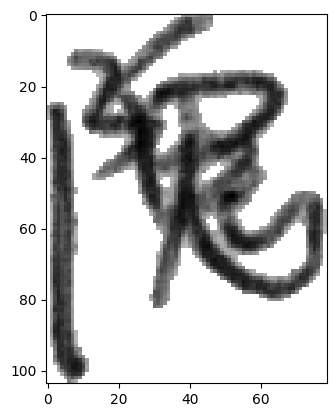

In [12]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

## Поделаем аугментацию

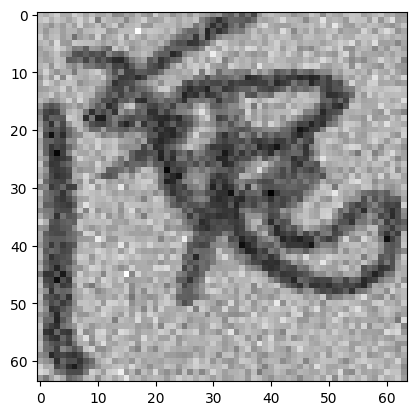

In [13]:
resized = (cv2.resize(img, (64, 64)) - 127.5) / 255.
gauss = np.random.normal(0,0.15,(64, 64))
plt.imshow(resized + gauss, cmap='gray')

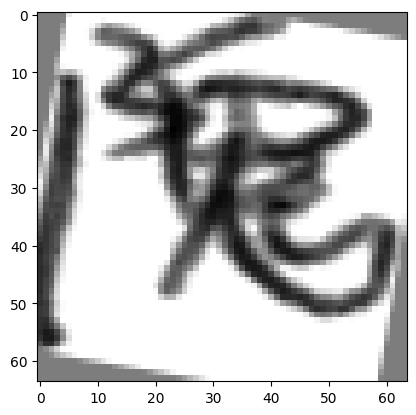

In [14]:
image_center = tuple(np.array(resized.shape[1::-1]) / 2)
angle = -10
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
result = cv2.warpAffine(resized, rot_mat, resized.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.imshow(result, cmap='gray')

С вероятностью 0.5 к изображению добавляется случайный шум, с вероятностью 0.5 независимо поворот c углом $\alpha \sim \mathbb{U}[-15, 15]$

In [15]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper, augment=False):
        self.helper = helper
        self.augment = augment

    def __len__(self):
        return self.helper.size()

    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        reshaped = (cv2.resize(img, (64, 64)) - 127.5) / 255.

        if self.augment:
          if np.random.randint(2):
            noise = np.random.normal(0,0.15,(64, 64))
            reshaped += noise
          if np.random.randint(2):
            image_center = tuple(np.array(reshaped.shape[1::-1]) / 2)
            angle = np.random.rand() * 30 - 15 # random from [-15, 15]
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            reshaped = cv2.warpAffine(reshaped, rot_mat, reshaped.shape[1::-1], flags=cv2.INTER_LINEAR)

        return reshaped, label

In [16]:
train_dataset = HWDBDataset(train_helper, augment=True)
val_dataset = HWDBDataset(val_helper, augment=False)

## Training


In [17]:
class Logger():
  def __init__(self, step=0, epoch=0):
    self.step = step
    self.epoch = epoch

  def __call__(self, metric, train=True):
    to_log = dict()
    if train:
      self.step += 1
      to_log = {'train_loss': metric}
    else:
      to_log = {'val_accuracy': metric, 'epoch': self.epoch}
      self.epoch += 1
    wandb.log(to_log, step=self.step)


In [18]:
from tqdm import tqdm


def val_epoch(val_loader, model, logger):
    model.eval()
    n_good = 0
    n_all = 0

    with torch.no_grad():
        for (X, y) in tqdm(val_loader):
            logits = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())

            n_all += len(classes)
    accuracy = n_good / n_all
    logger(accuracy, train=False)


def train_epoch(train_loader, model, optim, loss_fn, logger):
    for X, y in tqdm(train_loader):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())

        optim.zero_grad()
        loss.backward()
        optim.step()
        logger(loss.cpu().item(), train=True)

In [19]:
from models.CNN import MyCNN
from models.ViT import MyViT

from losses.arc_face import ArcFaceLoss


def make_pipeline_args(config, device='cuda'):
  if config['model'] == 'CNN':
    model = MyCNN(**config['model_args'])
  elif config['model'] == 'ViT':
    model = MyViT(**config['model_args'])
  else:
    assert False, 'Unknown model name'

  if config['loss'] == 'ArcFace':
    criterion = ArcFaceLoss(**config['loss_args'])
  elif config['loss'] == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss(**config['loss_args'])
  else:
    assert False, 'Unknown loss name'


  train_loader = DataLoader(train_dataset, **config['train_dataloader_args'])
  val_loader = DataLoader(val_dataset, **config['val_dataloader_args'])

  model.to(device)
  optimizer = torch.optim.AdamW(params=model.parameters(), **config['optim_args'])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, **config['scheduler_args'])

  return model, train_loader, val_loader, criterion, optimizer, scheduler


In [20]:
def model_pipeline(run_name, hyperparameters):

    with wandb.init(project='ocr_task2', config=hyperparameters, name=run_name):
      config = wandb.config

      model, train_loader, val_loader, criterion, optim, scheduler = make_pipeline_args(config)
      print(model)

      logger = Logger()

      epochs = hyperparameters['epochs']
      for epoch in range(epochs):
        train_epoch(train_loader, model, optim, criterion, logger)
        val_epoch(val_loader, model, logger)

        scheduler.step()

        torch.save(model.state_dict(), f"checkpoints/{config['model']}/{epoch}.pth")
      wandb.save(f"checkpoints/{config['model']}/*")

## CNN

In [21]:
from pathlib import Path

path = Path('checkpoints')
(path / 'CNN').mkdir(parents=True, exist_ok=True)

In [ ]:
run_name = 'CNN_AF'
hyperparameters = dict(
    epochs=10,
    model='CNN',
    model_args=dict(
        n_classes=train_helper.vocabulary.num_classes(),
        norm_out=True
    ),
    loss='CrossEntropy',
    loss_args=dict(
      label_smoothing=0.1
    ),
    train_dataloader_args=dict(
        batch_size=512,
        shuffle=True,
        drop_last=True,
        num_workers=8
    ),
    val_dataloader_args=dict(
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=8
    ),
    optim='AdamW',
    optim_args=dict(
        lr=0.002
    ),
    scheduler='ExponentialLR',
    scheduler_args=dict(
        gamma=0.1
    )
)

model_pipeline(run_name, hyperparameters)

## Vision Transformer

In [22]:
(path / 'ViT').mkdir(parents=True, exist_ok=True)

In [ ]:
run_name = 'ViT'
hyperparameters = dict(
    epochs=10,
    model='ViT',
    model_args=dict(
        patch_kernel=16,
        dim=128,
        layers=6,
        heads=4,
        ffn_dim=1024,
        n_classes=train_helper.vocabulary.num_classes(),
        norm_out=False
    ),
    loss='CrossEntropy',
    loss_args=dict(
      label_smoothing=0.1
    ),
    train_dataloader_args=dict(
        batch_size=512,
        shuffle=True,
        drop_last=True,
        num_workers=8
    ),
    val_dataloader_args=dict(
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=8
    ),
    optim='AdamW',
    optim_args=dict(
        lr=0.002
    ),
    scheduler='ExponentialLR',
    scheduler_args=dict(
        gamma=0.05
    )
)
model_pipeline(run_name, hyperparameters)

### Evaluation

У меня в итоге Vision Transformer выдал лучший accuracy. В wandb его можно увидеть на 3 эпохах. Лосс перестал падать даже с маленьким lr. Состояния модели остались в checkpoints - оттуда и взял.

In [37]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [38]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [43]:
preds = []
model = MyViT(patch_kernel=16,
        dim=128,
        layers=6,
        heads=4,
        ffn_dim=1024,
        n_classes=train_helper.vocabulary.num_classes(),
        norm_out=False
)

model.load_state_dict(torch.load(f'checkpoints/ViT/2.pth'))
model.eval()
model.cuda()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|█████████████████████████████████████████| 380/380 [00:53<00:00,  7.17it/s]


In [44]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [45]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9244890363839835